# Fokker-Planck 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

> $\partial_t u = \partial_{x}\left(M\partial_{x}\left(\frac{u}{M}\right)\right)$, $t > 0$, $x \in [-5,5]$.

> $u(0, x)=u^0(x), \quad x \in [-5, 5]$

> $\left(\frac{u}{M}\right)_x(t, -5)=\left(\frac{u}{M}\right)_x(t, 5)=0, \quad t \geq 0 .$


## Libraries

In [1]:
import sys
#sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')
sys.path.append('/home/juanfelipe/Desktop/research/kinetick/source')

In [2]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
from numpy.linalg import norm
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Test of `JAX` functionality

In [3]:
T = 2.
T_ = 3.
kernel = Gaussian
params = 1

$\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)|_{x=x_m,y=x_{m'}}$

In [4]:
partial_KoverMx(T,T_,kernel,params)

Array(13.44506721, dtype=float64, weak_type=True)

$M(x)\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)|_{x=x_m,y=x_{m'}}$

In [5]:
MtimesPartialx(T,T_,kernel,params)

Array(1.81959198, dtype=float64, weak_type=True)

$\partial_x\left(M(x)\partial_{x}\left(\frac{K(x,y)}{M(x)}\right)\right)|_{x=x_m,y=x_{m'}}$

In [6]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])

In [7]:
partial_MtimesPartialx(T,T_,kernel,params)

Array([[ 1.08268227e+00,  1.81959198e+00, -4.44089210e-16],
       [-1.33307958e-01, -4.02555153e-03, -3.72665317e-05]],      dtype=float64)

In [8]:
t = 2.
t_ = 4.
partial_MtimesPartialx_(t,t_,kernel,params)

Array(1.08268227, dtype=float64, weak_type=True)

In [9]:
T = 8.
T_ = 1.
kernel = Gaussian
params = 1

$\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)|_{x=x_m,y=x_{m'}}$

In [10]:
partial_KoverMy(T,T_,kernel,params)

Array(3.02010764e-10, dtype=float64, weak_type=True)

$M(y)\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)|_{x=x_m,y=x_{m'}}$

In [11]:
MtimesPartialy(T,T_,kernel,params)

Array(1.83178788e-10, dtype=float64, weak_type=True)

$\partial_y\left(M(y)\partial_{y}\left(\frac{K(x,y)}{M(y)}\right)\right)|_{x=x_m,y=x_{m'}}$

In [12]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])

In [13]:
partial_MtimesPartialy(T,T_,kernel,params)

Array([[-5.41341133e-01, -1.21306132e+00, -4.44089210e-16],
       [ 2.33288927e-01,  9.39295358e-03,  1.30432861e-04]],      dtype=float64)

Let's compute the biggest term

In [14]:
t = 2.
t_ = 3.
kernel = Gaussian
params = 1

In [15]:
partialy_partialx_MtimesPartialx_overMy_timesM(t,t_,kernel,params)

Array(6.0653066, dtype=float64, weak_type=True)

In [16]:
T = jnp.array([2.,7.])
T_ = jnp.array([4.,3.,2.])
kernel = Gaussian
params = 1

In [17]:
big_term(T,T_,kernel,params)

Array([[-4.06005850e+00,  3.55271368e-15,  6.00000000e+00],
       [-2.66615917e+00, -1.15734607e-01, -1.43103482e-03]],      dtype=float64)

## Utils

In [18]:
def Kphiphi_assembly(Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val1 = K(kernel, Xomega, Xomega, k_param) # K(X,X)
  val2 = partial_MtimesPartialx(Xomega, Xomega, kernel, k_param)
  val3 = partial_MtimesPartialy(Xomega, Xomega, kernel, k_param)
  val4 = big_term(Xomega, Xomega, kernel, k_param)
  val = val1 - h*val2 - h*val3 + (h**2)*val4  
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val1 = MtimesPartialx_(Xomega, Xboundary, kernel, k_param)
  val2 = big_term(Xomega, Xboundary, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = partial_partial(Xboundary, Xboundary, kernel, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [19]:
def Kphi_assembly(Xtest, Xomega, Xboundary , h, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian
  if k == 'Matern1':
    kernel = Matern_Kernel_1

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val1 = K(kernel, Xomega, Xtest, k_param)
  val2 = partial_MtimesPartialx(Xomega, Xtest, kernel, k_param)
  val = val1 - h*val2
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = partial_KoverMx_(Xboundary , Xtest, kernel, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

## How far can we go ?

In [20]:
# X_full
Xfull = np.linspace(-3,3,102)
# X_{\partial\Omega}
Xboundary = Xfull[[0,-1]]
# X_\Omega
Xomega = Xfull[1:-1]
# u(X_\Omega,0)
u0 = fp_1d_u0(Xomega)
# kernel
kernel = 'Gaussian'
# Kernel lenght-scale
k_param = 0.4
# Time step
h = 1e-2
# Final time - We add 0.1 since that is the initial condition
final_t = h + 0.1 
# nugget
nugget = 1e-8

Build `Kphiphi`

In [21]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, k = kernel, k_param = k_param)

Build `y_prev`

In [22]:
y_prev = jnp.concatenate((u0,np.zeros((len(Xboundary)),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [23]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)

Get `K(Xtest,Xfull)`

In [24]:
Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, h, k = kernel, k_param = k_param)

In [25]:
u_next = np.dot(Kphi.T,sol)

In [26]:
np.max(u_next)

0.8980034754410566

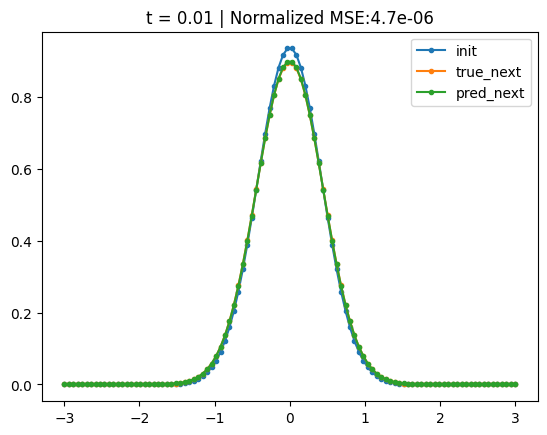

In [27]:
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings 
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
plt.legend()
plt.show()

## Let's take small steps 

Say we want to get to `t=0.2` by taking `h = 0.01`

In [28]:
final_t = 2
steps = int((t-0.1)//h)
# Initialize at the initial condition
uprev = u0
for _ in range(steps):
    y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
    sol = jnp.linalg.solve(Kphiphi + nugget*R,y_prev)
    u_next = np.dot(Kphi.T,sol)
    # update
    uprev = u_next[1:-1]

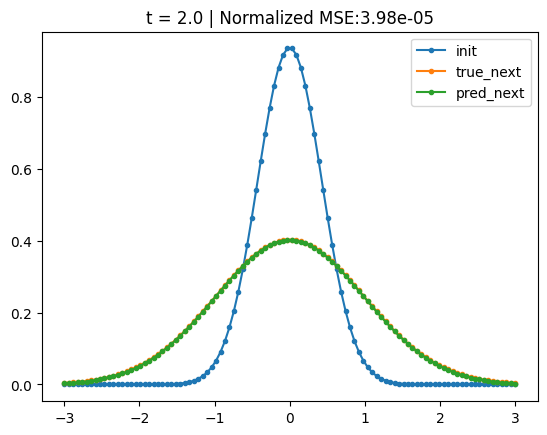

In [29]:
plt.figure()
# Initial condition
plt.plot(Xfull,fp_1d_u0(Xfull),'.-',label='init')
# True next
plt.plot(Xfull,fp_1d_sol(final_t, Xfull),'.-',label='true_next')
# Predicted next
plt.plot(Xfull,u_next,'.-',label='pred_next')
# Plot settings
nmse = mean_squared_error(u_next,fp_1d_sol(final_t, Xfull))/mean_squared_error(0*fp_1d_sol(final_t, Xfull),fp_1d_sol(final_t, Xfull))
plt.title('t = {} | Normalized MSE:{}'.format(t, round(nmse,7)))
plt.legend()
plt.show()

## Convergence

### Experiment 1

- $h = $`1e-4`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [ ]:
# Experiment 1 - L2-norms
L2_norms = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(-5,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-4
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.2415437640594517e-05
1.727030131840355e-07
1.348467734417518e-07
1.1890996711293657e-07
9.696317604924488e-08
8.697462699754864e-08
1.015297918987185e-07
1.673213082983715e-07


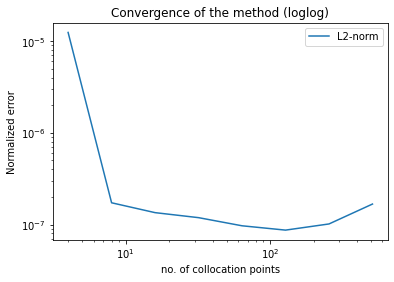

In [ ]:
# Experiment 1 - Convergence plot
plt.loglog(xrange,L2_norms,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 2

- $h = $`1e-6`
- $t= 0.15$
- Collocation points increasing from $2^2$ to $2^{10}$

In [ ]:
# Experiment 2 - L2-norms
L2_norms = []
xrange = 2**np.arange(2,10)
for n in range(2,10):
    # X_full
    Xfull = np.linspace(0,1,2**n+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 1e-5
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

1.0019170785092659e-05
1.2407221821359668e-06
5.153410590692563e-07
2.673173125391614e-07
1.3624461662996376e-07
6.29618738479488e-08
2.929894384128164e-08
1.5245934623159772e-08


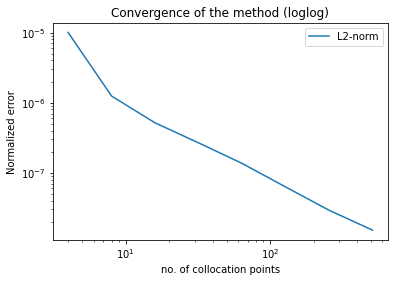

In [ ]:
# Experiment 2 - Convergence plot
plt.loglog(xrange,L2_norms,label = 'L2-norm')
plt.xlabel('no. of collocation points')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

- To get epsilon machine precision we should use Matérn and tune its hyperparms, but the nugget might not be needed for stability :O

### Experiment 3

- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^6$

In [ ]:
# Experiment 3 - L2-norms
L2_norms = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**6+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0010503342482250965
9.897117501981307e-06
9.696317604924488e-08
1.3624461662996376e-07


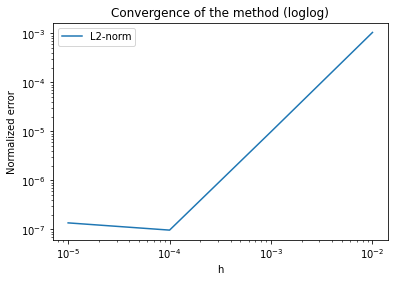

In [ ]:
# Experiment 3 - Convergence plot
plt.loglog(xrange,L2_norms,label = 'L2-norm')
plt.xlabel('h')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()

### Experiment 4

- $h$ decreasing from `1e-2` to `1e-5`
- $t= 0.15$
- Collocation points = $2^8$

In [ ]:
# Experiment 4 - L2-norms
L2_norms = []
xrange = 10.0**(-np.arange(2,6))
for n in range(2,6):
    # X_full
    Xfull = np.linspace(0,1,2**8+2)
    # Delta
    delta = Xfull[1]-Xfull[0]
    # X_{\partial\Omega}
    Xboundary = Xfull[[0,-1]]
    # X_\Omega
    Xomega = Xfull[1:-1]
    # u(X_\Omega,0)
    u0 = ad_u0(Xomega)
    # Advection coefficient
    beta = 5
    # Diffusion coefficient
    c = 1
    # Kernel lenght-scale
    k_param = 0.5
    # Time step
    h = 10**(-n)
    # Final t
    t = 0.15
    # No. of steps
    steps = int(t//h)
    # No. of eigenvalues
    n = 20
    # Compute Kphiphi
    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, h, beta, c, k = kernel, k_param = k_param)
    # Regularizer for Kphiphi
    R = jnp.diag(jnp.diag(Kphiphi))
    # Compute Kphi againts Xfull which will be the test set
    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary , h, beta, c, k = kernel, k_param = k_param)
    
    uprev = u0
    for _ in range(steps):
        y_prev = jnp.concatenate((uprev,np.zeros((len(Xboundary)),)))
        sol = jnp.linalg.solve(Kphiphi + nugget*R, y_prev)
        u_next = np.dot(Kphi.T,sol)
        # update
        uprev = u_next[1:-1]
    
    # Numerical
    u_next = np.dot(Kphi.T,sol)
    # Analytical
    u_true = ad_sol(Xfull, t, beta, c, n)   
    # Differences
    f = np.abs(u_next - u_true)**2
    # Append L2 norm per iteration
    L2_norms.append(trap(f,delta))
    # Print L2 norm per iteration
    print(trap(f,delta))

0.0010514423525215585
1.0790394960852565e-05
1.015297918987185e-07
2.929894384128164e-08


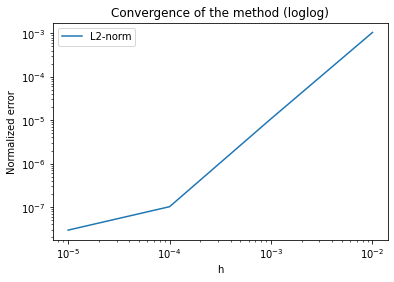

In [ ]:
# Experiment 4 - Convergence plot
plt.loglog(xrange,L2_norms,label = 'L2-norm')
plt.xlabel('h')
plt.ylabel('Normalized error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()